In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.utils import to_categorical
from matplotlib import pyplot

print('Importing')

Importing


In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teachers = []):
        super(Distiller, self).__init__()
        self.teachers = teachers
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teachers_predictions = 0
        for teacher in self.teachers : 
          teachers_predictions += teacher(x, training=False)
        
        teachers_predictions = teachers_predictions/len(self.teachers)


        with tf.GradientTape() as tape:
            # Forward pass of student
            
           
            student_predictions = self.student(x, training=True)
            

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teachers_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
           
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))


        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
       
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [ ]:
trainX, trainy, testX, testy = load_dataset('/content/gdrive/My Drive/')

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [ ]:
print(testy)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [ ]:
verbose, epochs, batch_size = 0, 15, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [ ]:
def createTeacherModel(shape,n_outputs):
  model = keras.Sequential()
  model.add(layers.LSTM(100,input_shape=(n_timesteps,n_features)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(100,activation='relu'))
  model.add(layers.Dense(n_outputs,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=[keras.metrics.CategoricalAccuracy()],)

  model.summary()

  return model


In [ ]:
teachers = []
teachers_hist = []
teachers_acc = []
for i in range(3):
  model = createTeacherModel(shape=(128,9),n_outputs=n_outputs)
  teachers_hist.append(model.fit(trainX,trainy,epochs=epochs,batch_size=batch_size,verbose=verbose))
  teachers_acc.append(model.evaluate(testX,testy,batch_size=batch_size,verbose=0))
  teachers.append(model)

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_106 (LSTM)              (None, 100)               44000     
_________________________________________________________________
dropout_106 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_210 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_211 (Dense)            (None, 6)                 606       
Total params: 54,706
Trainable params: 54,706
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: ignored

In [ ]:
tempeture = 1
tempeture_delta = 2
alpha = 0
alpha_delta = 0.2

student_hist = []
student_acc = []
tempeture_alpha = []
while alpha < 1 :
  tempeture = 1
  while tempeture < 10 :
    student = keras.Sequential()
    student.add(layers.LSTM(50,input_shape=(n_timesteps,n_features)))
    student.add(layers.Dropout(0.5))
    student.add(layers.Dense(20,activation='relu'))
    student.add(layers.Dense(n_outputs,activation='softmax'))

    distiller = Distiller(student=student,teachers=teachers)
    distiller.compile(
        optimizer= keras.optimizers.Adam(),
        metrics=[keras.metrics.CategoricalAccuracy()],
        student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=alpha,
        temperature=tempeture,
        )
    student_hist.append(distiller.fit(trainX,trainy,epochs=5))
    student_acc.append(distiller.evaluate(testX,testy))
    tempeture_alpha.append([tempeture,alpha])

    tempeture += tempeture_delta
  alpha += alpha_delta




Epoch 1/5
230/230 [==============================] - 26s 94ms/step - categorical_accuracy: 0.3856 - student_loss: 1.2280 - distillation_loss: 0.0620
Epoch 2/5
230/230 [==============================] - 21s 93ms/step - categorical_accuracy: 0.6050 - student_loss: 0.8195 - distillation_loss: 0.0424
Epoch 3/5
230/230 [==============================] - 21s 92ms/step - categorical_accuracy: 0.6753 - student_loss: 0.6729 - distillation_loss: 0.0346
Epoch 4/5
230/230 [==============================] - 21s 92ms/step - categorical_accuracy: 0.7103 - student_loss: 1.0138 - distillation_loss: 0.0411
Epoch 5/5
93/93 [==============================] - 2s 14ms/step - categorical_accuracy: 0.7540 - student_loss: 0.7728
Epoch 1/5
230/230 [==============================] - 25s 94ms/step - categorical_accuracy: 0.3749 - student_loss: 1.3544 - distillation_loss: 0.0060
Epoch 2/5
230/230 [==============================] - 21s 93ms/step - categorical_accuracy: 0.5287 - student_loss: 1.0896 - distillation_l

[]

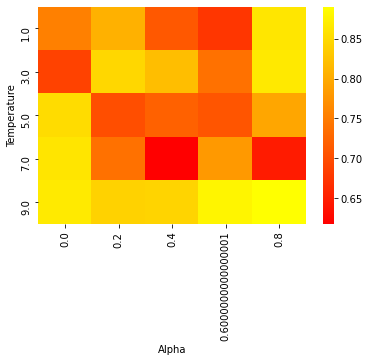

In [ ]:
# HeatMap tempeter - alpha - accuracy
import pandas as pd
import seaborn as sns

student_acc_arr = np.array(student_acc)
tempeture_alpha_arr = np.array(tempeture_alpha)

heatmap = pd.DataFrame({'Temperature': tempeture_alpha_arr[:, 0], 'Alpha': tempeture_alpha_arr[:, 1], 'acc' : student_acc_arr[:,0] })

table = pd.pivot_table(heatmap, values='acc',
                       index=['Temperature'], 
                         columns=['Alpha'], aggfunc=np.mean)
ax = sns.heatmap(table,cmap='autumn')

pyplot.plot()

In [ ]:
best_student = student_hist[24]

print("Best student accuracy :  : %g"% (student_acc_arr[24][0]))

Best student accuracy :  : 0.890397


In [ ]:
for teacher in teachers :
  _, accuracy = teacher.evaluate(testX,testy,batch_size=batch_size,verbose=0)
  accuracy = accuracy * 100.0
  print("Teachers accuracy :  : %g"% (accuracy))


Teachers accuracy :  : 90.5667
Teachers accuracy :  : 90.7363
Teachers accuracy :  : 89.3112


In [ ]:
student_iso = keras.Sequential()
student_iso.add(layers.LSTM(50,input_shape=(n_timesteps,n_features)))
student_iso.add(layers.Dropout(0.5))
student_iso.add(layers.Dense(20,activation='relu'))
student_iso.add(layers.Dense(n_outputs,activation='softmax'))

student_iso.compile(loss='categorical_crossentropy',optimizer='adam', metrics=[keras.metrics.CategoricalAccuracy()],)

hist_non_dist = student_iso.fit(trainX,trainy,epochs=5,batch_size=batch_size,verbose=verbose)
_, accuracy = student_iso.evaluate(testX,testy,batch_size=batch_size,verbose=0)
accuracy = accuracy * 100.0
print("Student isoler accuracy :  : %g"% (accuracy))

Student isoler accuracy :  : 74.0753


In [ ]:
print(best_student.history.keys())

dict_keys(['categorical_accuracy', 'student_loss', 'distillation_loss'])


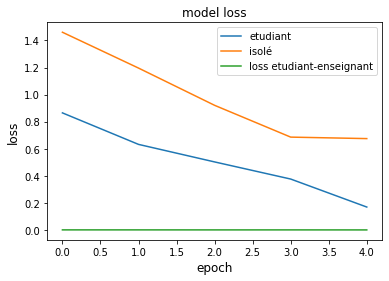

In [ ]:

plt.figure()


plt.plot(best_student.history['student_loss'])
plt.plot(hist_non_dist.history['loss'])
plt.plot(best_student.history['distillation_loss'])

plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['etudiant', 'isolé','loss etudiant-enseignant'], loc='upper right')
plt.show()
plt.close()